In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [4]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.9.2


In [5]:
column_names = ["Calories (kcal)", 'Protein (g)','Fats (g)', 'Carbs (g)','Sugar (g)',"Glycemic index"]

In [6]:
raw_dataset = pd.read_csv("/gdrive/Shareddrives/FYP Project/Dataset/FoodData_modified.csv")
dataset = raw_dataset[column_names]

In [7]:
dataset.tail()

,Calories (kcal),Protein (g),Fats (g),Carbs (g),Sugar (g),Glycemic index
621,12,1.10,0.17,2.23,NaN,32.0
622,93,5.60,2.12,17.31,6.3,NaN
623,281,11.86,8.20,51.42,NaN,NaN
624,32,0.33,0.52,7.44,NaN,NaN
625,284,9.25,0.73,73.01,NaN,45.0


In [8]:
dataset.isna().sum()

Calories (kcal)      0
Protein (g)          0
Fats (g)             0
Carbs (g)            0
Sugar (g)          141
Glycemic index      76
dtype: int64

In [9]:
dataset = dataset.dropna()

In [10]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [11]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Calories (kcal),345.0,225.414493,192.418344,0.0,59.00,198.00,338.00,884.00
Protein (g),345.0,8.294290,9.374438,0.0,1.10,4.10,14.37,75.16
Fats (g),345.0,11.580116,19.572659,0.0,0.25,2.34,16.07,100.00
Carbs (g),345.0,22.629971,26.151048,0.0,3.09,11.29,33.33,99.98
Sugar (g),345.0,9.274493,16.936808,0.0,0.40,2.50,8.90,99.80
Glycemic index,345.0,34.982609,25.048900,0.0,15.00,32.00,54.00,104.00


In [12]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('Glycemic index')
test_labels = test_features.pop('Glycemic index')

In [13]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
Calories (kcal),225.414493,192.418344
Protein (g),8.294290,9.374438
Fats (g),11.580116,19.572659
Carbs (g),22.629971,26.151048
Sugar (g),9.274493,16.936808
Glycemic index,34.982609,25.048900


In [14]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [15]:
normalizer.adapt(np.array(train_features))

In [16]:
print(normalizer.mean.numpy())

[[225.415   8.294  11.58   22.63    9.274]]


In [17]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[45.   0.7  0.2 10.4  8.4]]

Normalized: [[-0.94 -0.81 -0.58 -0.47 -0.05]]


# Section1 Use one feature

In [18]:
calories = np.array(train_features['Calories (kcal)'])

calories_normalizer = layers.Normalization(input_shape=[1,], axis=None)
calories_normalizer.adapt(calories)

In [19]:
calories_model = tf.keras.Sequential([
    calories_normalizer,
    layers.Dense(units=1)
])

calories_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [20]:
calories_model.predict(calories[:10])

1/1 [==============================] - 0s 75ms/step


array([[ 1.402],
       [ 1.434],
       [ 1.107],
       [-1.155],
       [-2.585],
       [ 1.014],
       [-0.16 ],
       [-0.005],
       [-0.541],
       [-0.106]], dtype=float32)

In [21]:
calories_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [22]:
%%time
history = calories_model.fit(
    train_features['Calories (kcal)'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 2.97 s, sys: 151 ms, total: 3.13 s
Wall time: 3.14 s


In [23]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,20.201210,21.473698,95
96,20.205269,21.472649,96
97,20.197643,21.475571,97
98,20.202044,21.479462,98
99,20.198784,21.479393,99


In [24]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  # plt.ylim([0, ])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Glycemic Index]')
  plt.legend()
  plt.grid(True)

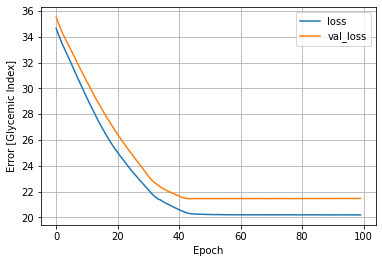

In [25]:
plot_loss(history)

In [26]:
test_results = {}

test_results['calories_model'] = calories_model.evaluate(
    test_features['Calories (kcal)'],
    test_labels, verbose=0)

In [27]:
x = tf.linspace(0.0, 1000, 1001)
y = calories_model.predict(x)

32/32 [==============================] - 0s 866us/step


In [28]:
def plot_calories(x, y):
  plt.scatter(train_features['Calories (kcal)'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Calories')
  plt.ylabel('Glycemic Index')
  plt.legend()

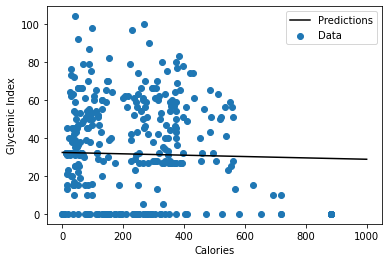

In [29]:
plot_calories(x, y)

# Section2 Linear regression on all features 

In [30]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [31]:
linear_model.predict(train_features[:10])

1/1 [==============================] - 0s 49ms/step


array([[ 0.104],
       [-0.026],
       [-0.083],
       [-2.791],
       [-1.448],
       [ 0.166],
       [ 0.363],
       [-0.267],
       [ 0.11 ],
       [-0.377]], dtype=float32)

In [32]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(5, 1) dtype=float32, numpy=
array([[-0.254],
       [ 0.506],
       [ 0.183],
       [-0.906],
       [ 0.816]], dtype=float32)>

In [33]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [34]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: user 3.03 s, sys: 138 ms, total: 3.17 s
Wall time: 3.07 s


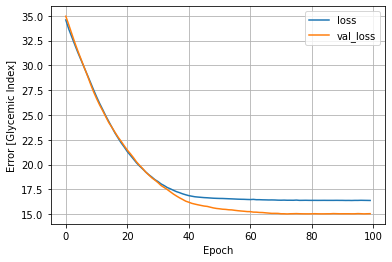

In [35]:
plot_loss(history)

In [36]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

# Section3 Regression with DNN

In [52]:
def build_and_compile_model(norm, stack=[
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ]):
  stack.insert(0, normalizer)
  model = keras.Sequential(stack)

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [38]:
dnn_calories_model = build_and_compile_model(calories_normalizer)

In [39]:
dnn_calories_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                128       
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [40]:
%%time
history = dnn_calories_model.fit(
    train_features['Calories (kcal)'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 3.12 s, sys: 171 ms, total: 3.29 s
Wall time: 5.45 s


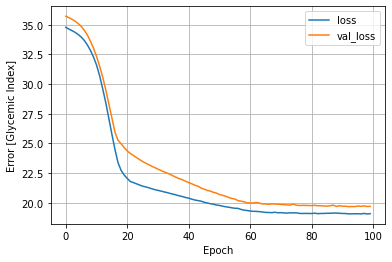

In [41]:
plot_loss(history)

In [42]:
x = tf.linspace(0.0, 1000, 1001)
y = dnn_calories_model.predict(x)

32/32 [==============================] - 0s 821us/step


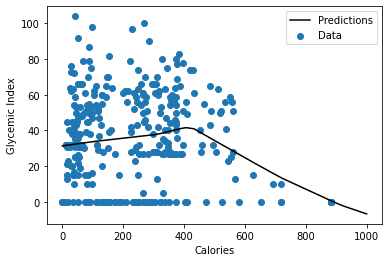

In [43]:
plot_calories(x, y)

In [44]:
test_results['dnn_calories_model'] = dnn_calories_model.evaluate(
    test_features['Calories (kcal)'], test_labels,
    verbose=0)

In [45]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 5)                11        
 n)                                                              
                                                                 
 dense_5 (Dense)             (None, 64)                384       
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,620
Trainable params: 4,609
Non-trainable params: 11
_________________________________________________________________


In [46]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 3.27 s, sys: 153 ms, total: 3.42 s
Wall time: 3.42 s


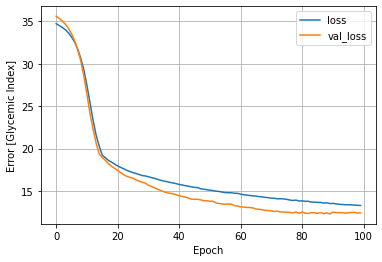

In [47]:
plot_loss(history)

In [48]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

#Section4 DNN2

In [55]:
dnn2_stack = [
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
]
dnn2_model = build_and_compile_model(normalizer, dnn2_stack)
dnn2_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 5)                11        
 n)                                                              
                                                                 
 dense_19 (Dense)            (None, 64)                384       
                                                                 
 dense_20 (Dense)            (None, 64)                4160      
                                                                 
 dense_21 (Dense)            (None, 64)                4160      
                                                                 
 dense_22 (Dense)            (None, 1)                 65        
                                                                 
Total params: 8,780
Trainable params: 8,769
Non-trainable params: 11
___________________________________________________

In [56]:
%%time
history = dnn2_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 3.73 s, sys: 150 ms, total: 3.88 s
Wall time: 5.57 s


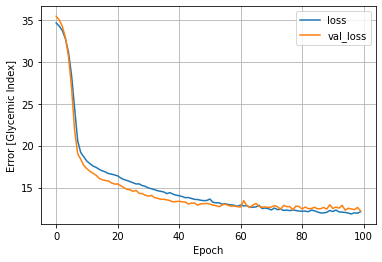

In [57]:
plot_loss(history)

In [58]:
test_results['dnn2_model'] = dnn2_model.evaluate(test_features, test_labels, verbose=0)

#Section DNN3 4 hidden layers

In [62]:
dnn3_stack = [
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
]
dnn3_model = build_and_compile_model(normalizer, dnn3_stack)
dnn3_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 5)                11        
 n)                                                              
                                                                 
 dense_23 (Dense)            (None, 64)                384       
                                                                 
 dense_24 (Dense)            (None, 64)                4160      
                                                                 
 dense_25 (Dense)            (None, 64)                4160      
                                                                 
 dense_26 (Dense)            (None, 64)                4160      
                                                                 
 dense_27 (Dense)            (None, 1)                 65        
                                                      

In [63]:
%%time
history = dnn3_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 3.55 s, sys: 207 ms, total: 3.75 s
Wall time: 5.49 s


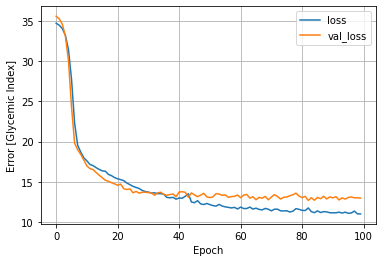

In [64]:
plot_loss(history)

In [65]:
test_results['dnn3_model'] = dnn3_model.evaluate(test_features, test_labels, verbose=0)

#Section DNN4 4 hidden layers

In [67]:
dnn4_stack = [
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
]
dnn4_model = build_and_compile_model(normalizer, dnn4_stack)
dnn4_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 5)                11        
 n)                                                              
                                                                 
 dense_28 (Dense)            (None, 64)                384       
                                                                 
 dense_29 (Dense)            (None, 64)                4160      
                                                                 
 dense_30 (Dense)            (None, 64)                4160      
                                                                 
 dense_31 (Dense)            (None, 64)                4160      
                                                                 
 dense_32 (Dense)            (None, 64)                4160      
                                                      

In [69]:
%%time
history = dnn4_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 3.54 s, sys: 212 ms, total: 3.76 s
Wall time: 5.53 s


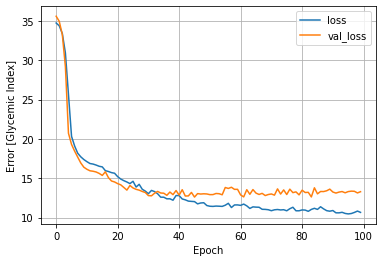

In [70]:
plot_loss(history)

In [71]:
test_results['dnn4_model'] = dnn4_model.evaluate(test_features, test_labels, verbose=0)

#Section Summary

In [72]:
pd.DataFrame(test_results, index=['Mean absolute error [Glycemic Index]']).T

,Mean absolute error [Glycemic Index]
calories_model,21.207014
linear_model,15.723081
dnn_calories_model,19.521524
dnn_model,14.682681
dnn2_model,13.250913
dnn3_model,13.662339
dnn4_model,14.008393


3/3 [==============================] - 0s 3ms/step


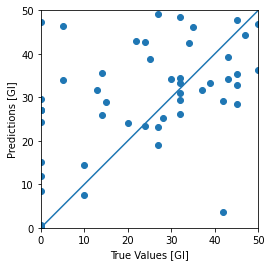

In [73]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [GI]')
plt.ylabel('Predictions [GI]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

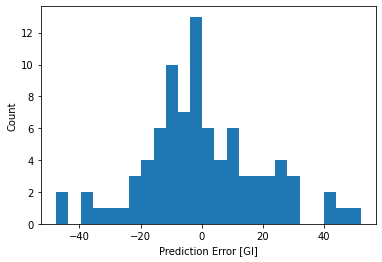

In [74]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [GI]')
_ = plt.ylabel('Count')